## imports

In [3]:
import math
import os
import sys

import collections
from copy import copy, deepcopy
import json
from collections import Counter
from io import BytesIO
import zipfile
from glob import glob
import shelve

from tqdm.notebook import tqdm
from IPython.display import display
import lightgbm as ltb
import numpy as np
import pandas as pd
pd.set_option("display.precision", 4)
import rasterio
from rasterio.io import MemoryFile
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
try:
    import torchvision.transforms.F as F
except:
    import torchvision.transforms.functional as F

from matplotlib import pyplot as plt
%matplotlib inline

import joblib
from sklearn import datasets
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, average_precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

from datadings.reader import ZipFileReader, MsgpackReader
from datadings.writer import FileWriter


In [2]:
!pip install scikit-multilearn
from skmultilearn.model_selection import IterativeStratification

!pip install pickle-mixin
import pickle

#!pip install flaml[notebook]
!pip install flaml

import warnings
warnings.filterwarnings('ignore', message='pandas.Int64Index', category=FutureWarning)
os.environ["PYTHONWARNINGS"] = "ignore:pandas.Int64:FutureWarning"

from flaml import AutoML

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
     |████████████████████████████████| 89 kB 12.1 MB/s eta 0:00:01
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=5998 sha256=81cf0b41da700922e84b0791b811f3ff07923989a2f96a4137c59f49fe71f04a
  Stored in directory: /root/.cache/pip/wheels/58/c6/8b/061bd4edc8cea2b2235758c3e50473d08499236fbfdd21e6b3
Successfully built pickle-mixin
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
     |████████████████████████████████| 196 kB 12.0 MB/s eta 0:00:01
     |████████████████████████████████| 157.5 MB 335 kB/s  eta 0:00:01


## global variables

In [5]:
# BASE_PATH must be the directory with the files downloaded from Zenodo.
# For instance, '/home/<username>/treesatai_benchmark_archive/zenodo/'.
#
# RESNET_WEIGHTS_FILE is the file containing the pre-trained ResNet18 weights used to extract features
# that are fed to the LightGBM classifier. See section 3 of the paper for details. By default, it is
# located in the same directory as this notebook file, but feel free to store it somewhere else and
# update the path accordingly.

BASE_PATH = '/path/to/treesatai_benchmark_archive/zenodo/' # this is an example; must be adapted
LABELS_FILE = os.path.join(BASE_PATH, 'labels.zip/labels/TreeSatBA_v9_60m_multi_labels.json')
RES_SENTINEL = '60m'                                       # resolution of the Sentinel (1 and 2) sensor

TRAIN_FILENAMES = open(os.path.join(BASE_PATH, 'train_filenames.lst')).read().split()
TEST_FILENAMES = open(os.path.join(BASE_PATH, 'test_filenames.lst')).read().split()
RESNET_WEIGHTS_FILE = 'ResNet_PT_FT_Aerial3Bands_Norm_Imgnet_v9_100.pt'

TIME_BUDGET = 30*60                                        # time for param tuning in seconds

## loading data

In [4]:
def read_multilabels(fn):
    zfn,inner = fn.split('.zip/')
    zfn = zfn + '.zip'
    with zipfile.ZipFile(zfn) as z:
        with z.open(inner) as f:
            return json.load(f)
multilabels_dict = read_multilabels(LABELS_FILE)

# hack for missing file?!?
#multilabels_dict['Betula_spec._4_324455_BI_NLF.tif'] = [['Betula', 1.0]]

In [6]:
class_counts = Counter()
for mls in multilabels_dict.values():
    for ml, p in mls:
        class_counts[ml] += 1
class_counts.most_common()

[('Quercus', 15524),
 ('Fagus', 14382),
 ('Picea', 14169),
 ('Pinus', 13748),
 ('Cleared', 7080),
 ('Larix', 6388),
 ('Pseudotsuga', 5754),
 ('Betula', 4346),
 ('Alnus', 4207),
 ('Acer', 3819),
 ('Fraxinus', 3378),
 ('Abies', 1616),
 ('Populus', 684),
 ('Prunus', 482),
 ('Tilia', 286)]

In [7]:
classes = sorted(class_counts)
classes

['Abies',
 'Acer',
 'Alnus',
 'Betula',
 'Cleared',
 'Fagus',
 'Fraxinus',
 'Larix',
 'Picea',
 'Pinus',
 'Populus',
 'Prunus',
 'Pseudotsuga',
 'Quercus',
 'Tilia']

In [8]:
len(classes)

15

In [9]:
def convert_binary(labels):
    vec = np.zeros(len(classes), dtype = np.uint8)
    for lab, _ in labels:
        # get index from original class list
        idx = classes.index(lab)
        vec[idx] = 1
    return vec

In [10]:
def decode_images(sample):
    sample['data'] = MemoryFile(sample['data']).open().read()
    return sample

In [11]:
def initfun(sample):
    key = sample['path'].rsplit('/', 1)[-1]
    sample['key'] = key
    sample['label'] = key.split('_', 1)[0]

def _gen_from_zip_file(filename, pattern):
    for sample in ZipFileReader(filename, pattern, initfun=initfun, numeric_labels=False):
        
        #sample['data'] = MemoryFile(sample['data']).open().read()
        
        key = sample['key']
        try:
            labels = multilabels_dict[key]
            sample['multilabels'] = labels
            sample['labelvec'] = convert_binary(labels)

            yield sample
        except KeyError:
            print('WARNING: no entry for', key, 'in multilabels file')

In [12]:
import multiprocessing as mp
def gen_from_zip_files(filepat, inner_pattern):
    with mp.Pool(16) as pool:
        fns = sorted(glob(filepat))
        for fn in fns:
            for sample in pool.imap(decode_images, _gen_from_zip_file(fn, inner_pattern)):
                yield sample

In [13]:
fn_pats = (
    ("aerial", os.path.join(BASE_PATH, 'aerial_*.zip'), '*.tif'),
    ("s1", os.path.join(BASE_PATH, 's1.zip'), os.path.join('s1', RES_SENTINEL, '*.tif')),
    ("s2", os.path.join(BASE_PATH, 's2.zip'), os.path.join('s2', RES_SENTINEL, '*.tif')),
)

In [14]:
# converting input files into datadings msgpack format
# useful for much faster reading in future, e.g., by iterating dataloaders (not keeping all in mem)
# only has to be done once
for name, fnpat, pat in fn_pats:
    if os.path.exists(os.path.join(BASE_PATH, name + '.msgpack')):
        continue
    with FileWriter(os.path.join(BASE_PATH, name + '.msgpack'), overwrite=True) as writer:
        for sample in gen_from_zip_files(fnpat, pat):
            writer.write(sample)

In [15]:
len(multilabels_dict)

50382

In [16]:
with MsgpackReader(os.path.join(BASE_PATH, 'aerial.msgpack')) as reader:
    for sample in tqdm(reader):
        pass
sample

  0%|          | 0/50381 [00:00<?, ?it/s]

{'key': 'Tilia_spec._9_99911_WEFL_NLF.tif',
 'label': 'Tilia',
 'path': 'Tilia_spec._9_99911_WEFL_NLF.tif',
 '_additional_info': [],
 'data': array([[[213, 214, 205, ..., 213, 215, 207],
         [210, 188, 205, ..., 199, 209, 194],
         [205, 171, 195, ..., 189, 205, 179],
         ...,
         [203, 194, 191, ..., 175, 188, 196],
         [221, 209, 203, ..., 178, 186, 184],
         [204, 194, 196, ..., 182, 192, 194]],
 
        [[143, 144, 135, ..., 171, 173, 165],
         [139, 117, 134, ..., 157, 167, 152],
         [136, 102, 125, ..., 147, 163, 137],
         ...,
         [132, 123, 120, ..., 137, 152, 159],
         [150, 138, 132, ..., 140, 150, 147],
         [134, 124, 126, ..., 146, 155, 157]],
 
        [[129, 130, 121, ..., 144, 146, 138],
         [128, 106, 123, ..., 130, 140, 125],
         [126,  92, 118, ..., 122, 138, 112],
         ...,
         [131, 122, 119, ..., 112, 126, 136],
         [149, 137, 131, ..., 115, 124, 124],
         [130, 120, 122, ...,

In [17]:
def get_item_by_key(self, key):
    self.seek_key(key)
    return next(self)

In [18]:
with MsgpackReader(os.path.join(BASE_PATH, 'aerial.msgpack')) as reader:
    s = get_item_by_key(reader, TRAIN_FILENAMES[0])
s

{'key': 'Abies_alba_0_2545_WEFL_NLF.tif',
 'label': 'Abies',
 'path': 'Abies_alba_0_2545_WEFL_NLF.tif',
 '_additional_info': [],
 'data': array([[[160, 139, 157, ..., 154, 149, 156],
         [160, 147, 154, ..., 151, 153, 150],
         [153, 158, 157, ..., 157, 162, 152],
         ...,
         [159, 154, 163, ..., 178, 173, 177],
         [150, 147, 146, ..., 189, 189, 189],
         [138, 140, 137, ..., 147, 150, 157]],
 
        [[164, 145, 161, ..., 139, 134, 139],
         [167, 154, 161, ..., 136, 136, 131],
         [164, 169, 168, ..., 139, 143, 130],
         ...,
         [135, 128, 133, ..., 162, 150, 150],
         [129, 123, 119, ..., 184, 177, 170],
         [117, 118, 110, ..., 152, 148, 148]],
 
        [[145, 128, 144, ..., 113, 108, 114],
         [152, 140, 147, ..., 111, 112, 108],
         [153, 160, 157, ..., 120, 122, 108],
         ...,
         [104,  98, 104, ..., 122, 114, 118],
         [ 98,  93,  90, ..., 140, 135, 131],
         [ 91,  92,  84, ..., 107

In [19]:
#del multilabels_test, multilabels_train, labels_test, labels_train, aerial_test, aerial_train, s1_test, s1_train, s2_test, s2_train

v = vars()

if os.path.exists(os.path.join(BASE_PATH, 'aerial_test.npy')):
    # slight shortcut for above
    for _n in 'multilabels_test, multilabels_train, labels_test, labels_train, aerial_test, aerial_train, s1_test, s1_train, s2_test, s2_train'.split(', '):
        fn = os.path.join(BASE_PATH, _n + '.npy')
        v[_n] = np.load(fn)
else:
    for t in ['train', 'test']:
        fns = v[f'{t.upper()}_FILENAMES']

        for ds in ['s1', 's2', 'aerial']:

            with MsgpackReader(os.path.join(BASE_PATH, f'{ds}.msgpack')) as reader:
                if ds == 's1':
                    # use s1 to get labels as it's the smallest / fastest
                    v[f'multilabels_{t}'] = np.array([get_item_by_key(reader, fn)['labelvec'] for fn in tqdm(fns, desc=f'multilabels_{t}')])
                    v[f'labels_{t}'] = np.array([classes.index(get_item_by_key(reader, fn)['label']) for fn in tqdm(fns, desc=f'labels_{t}')])

                v[f'{ds}_{t}'] = np.array([get_item_by_key(reader, fn)['data'] for fn in tqdm(fns, desc=f'{ds}_{t}')])

    # save results of this cell
    for _n in 'multilabels_test, multilabels_train, labels_test, labels_train, aerial_test, aerial_train, s1_test, s1_train, s2_test, s2_train'.split(', '):
        fn = os.path.join(BASE_PATH, _n + '.npy')
        np.save(fn, v[_n])

In [20]:
multilabels_train.shape, multilabels_test.shape

((45337, 15), (5044, 15))

In [21]:
labels_train.shape, labels_test.shape

((45337,), (5044,))

In [22]:
aerial_train.shape, aerial_test.shape

((45337, 4, 304, 304), (5044, 4, 304, 304))

In [23]:
s1_train.shape, s1_test.shape

((45337, 3, 6, 6), (5044, 3, 6, 6))

In [24]:
s2_train.shape, s2_test.shape

((45337, 12, 6, 6), (5044, 12, 6, 6))

In [25]:
multilabels_train[0]

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], dtype=uint8)

In [26]:
labels_train[0]

0

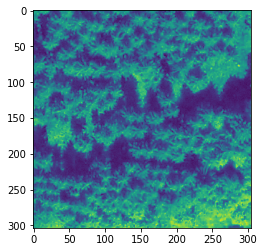

In [27]:
plt.imshow(aerial_train[0][0])

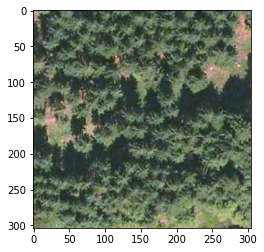

In [28]:
# show aerial RGB bands (3,1,2)... 0 is near infrared
plt.imshow(np.dstack(aerial_train[0][[3,1,2]]))

In [29]:
aerial_train.shape

(45337, 4, 304, 304)

In [30]:
# doesn't look green? let's try getting mean values for bands...
aerial_train.mean(axis=(0, 2, 3))

array([150.97992526,  93.01403697,  85.00857057,  80.97255149])

In [31]:
# weird, would've expected NIR-R-G-B, so G = aerial_train[:, 2] to have a higher values than R or B???

In [32]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(4*len(imgs), 3))
    for i, img in enumerate(imgs):
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

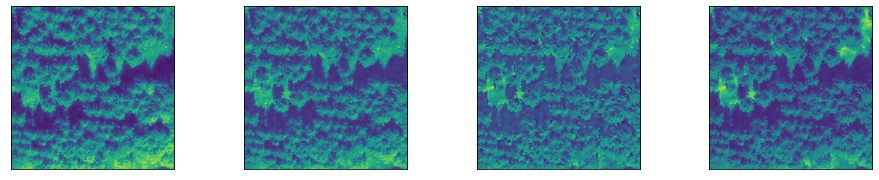

In [33]:
show(list(aerial_train[0]))

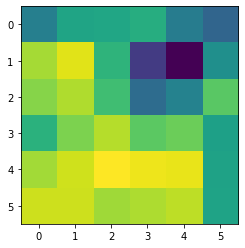

In [34]:
plt.imshow(s1_train[0][0])

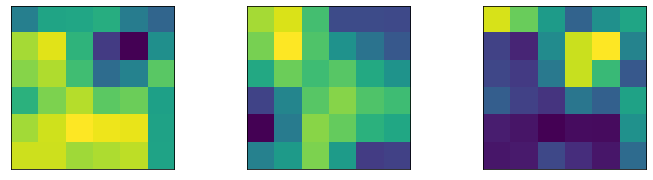

In [35]:
show(list(s1_train[0]))

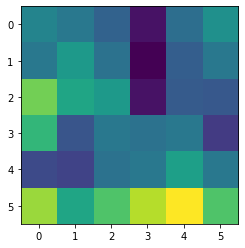

In [36]:
plt.imshow(s2_train[0][0])

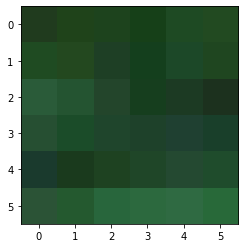

In [37]:
# RGB are first in our s2 data
plt.imshow(np.dstack(s2_train[0][[0,1,2]]/750))

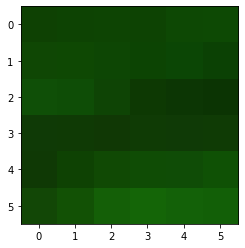

In [38]:
# show s2 RGB Bands (4,3,2)  # warning, were re-ordered
plt.imshow(np.dstack(s2_train[0][[4,3,2]]/6000))

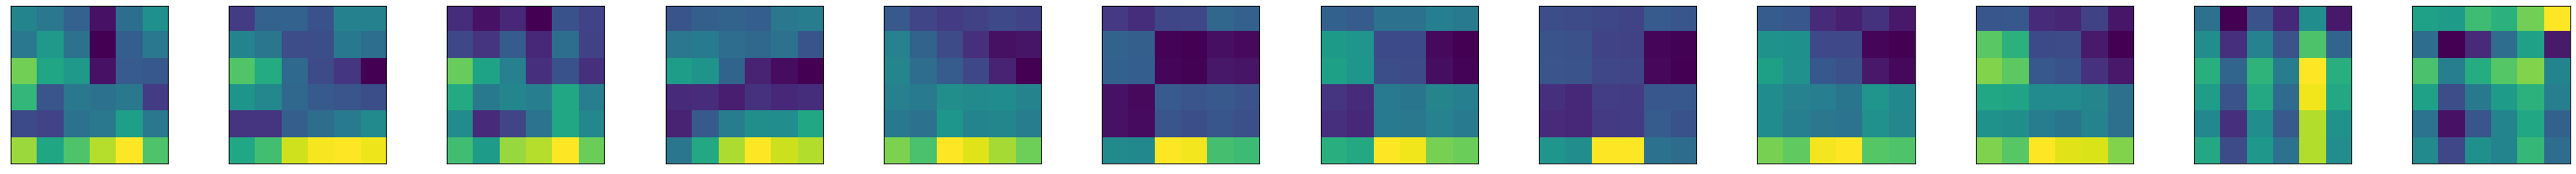

In [39]:
show(list(s2_train[0]))

## preprocess aerial (ResNet features)

In [40]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True).eval()
weights = torch.load(RESNET_WEIGHTS_FILE, map_location=torch.device('cpu'))
torch.set_num_threads(min(64, joblib.cpu_count()))  # lots of red bars... sys time...
resnet.weights = weights
feature_extractor = torch.nn.Sequential(*list(resnet.children())[:-1])

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [41]:
mean = aerial_train[:, [3,1,2], :, :].mean(axis=(0, 2, 3))
stddev = aerial_train[:, [3,1,2], :, :].std(axis=(0, 2, 3))

In [42]:
crop = (aerial_train.shape[-1] - 224) // 2
prep_aerial_train = (aerial_train[:, [3,1,2], crop:-crop, crop:-crop] - mean.reshape(1, 3, 1, 1)) / stddev.reshape(1, 3, 1, 1)
prep_aerial_test = (aerial_test[:, [3,1,2], crop:-crop, crop:-crop] - mean.reshape(1, 3, 1, 1)) / stddev.reshape(1, 3, 1, 1)

In [43]:
with torch.no_grad():
    feats_aerial_train = feature_extractor(torch.tensor(prep_aerial_train, dtype=torch.float32)).squeeze().detach().numpy()
    feats_aerial_test = feature_extractor(torch.tensor(prep_aerial_test, dtype=torch.float32)).squeeze().detach().numpy()

## simple single labels lightgbm training

In [44]:
X_train = s2_train.reshape(len(labels_train), -1)
y_train = labels_train
X_test = s2_test.reshape(len(labels_test), -1)
y_test = labels_test

In [45]:
# clf = ltb.LGBMClassifier(
#     boosting_type='gbdt',
#     objective='multiclass',
#     num_class=len(classes),
#     learning_rate=LEARNING_RATE,
#     n_estimators=NUM_ESTIMATORS,
#     #verbose=1,
# )

clf = ltb.LGBMClassifier(n_jobs=min(32, joblib.cpu_count()))  # seems more than 32 actually slows things down
clf.fit(X_train, y_train)

LGBMClassifier(n_jobs=32)

LightGBM Model accuracy score: 0.5710
              precision    recall  f1-score   support

       Abies       0.54      0.40      0.46        93
        Acer       0.36      0.22      0.27       282
       Alnus       0.25      0.11      0.15       247
      Betula       0.37      0.22      0.28       281
     Cleared       0.63      0.75      0.69       422
       Fagus       0.55      0.73      0.63       639
    Fraxinus       0.35      0.23      0.28       255
       Larix       0.51      0.39      0.44       316
       Picea       0.68      0.78      0.73       571
       Pinus       0.69      0.80      0.74       759
     Populus       0.62      0.06      0.11        81
      Prunus       0.25      0.07      0.11        29
 Pseudotsuga       0.64      0.52      0.57       278
     Quercus       0.53      0.68      0.59       769
       Tilia       0.08      0.05      0.06        22

    accuracy                           0.57      5044
   macro avg       0.47      0.40      0.4

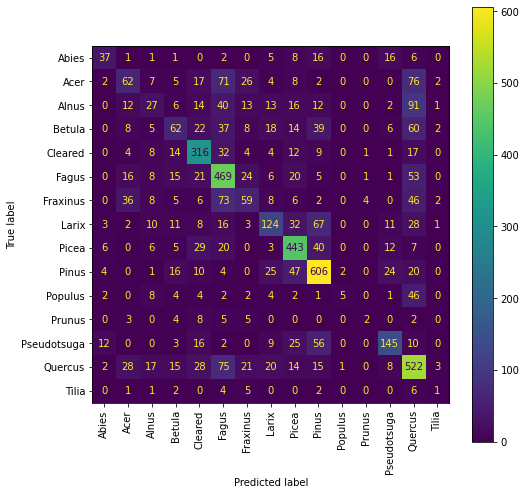

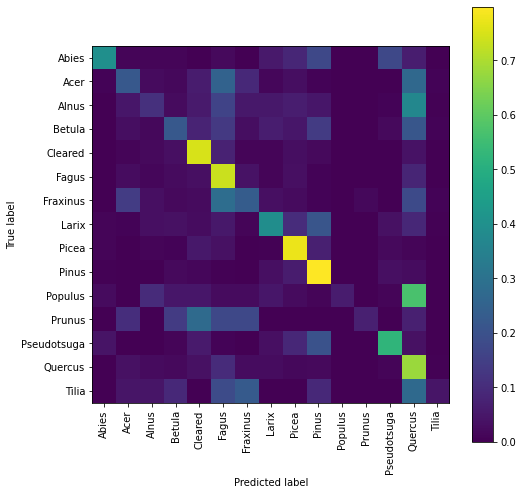

In [46]:
y_pred=clf.predict(X_test)

accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=classes, zero_division=0))
# cm = confusion_matrix(y_test, y_pred)
# print(cm)
fig, ax = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=classes, xticks_rotation='vertical', ax=ax)
plt.show()
fig, ax = plt.subplots(figsize=(8,8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=classes, xticks_rotation='vertical', normalize='true', include_values=False, ax=ax)
plt.show()

### param tuning

In [47]:
# automl = AutoML()
# automl.fit(
#     X_train,
#     y_train,
#     task="classification",
#     metric='macro_f1', # 'accuracy', 'micro_f1'
#     time_budget=10*60,
#     estimator_list=['lgbm'],
#     verbose=1,
#     n_jobs=min(32, joblib.cpu_count())
# )
# y_pred=automl.predict(X_test)

# print(classification_report(y_test, y_pred, target_names=classes, zero_division=0))
# cm = confusion_matrix(y_test, y_pred)
# print(cm)

## simple multilabel lightgbm

In [48]:
X_train = s2_train.reshape(len(labels_train), -1)
y_train = multilabels_train
X_test = s2_test.reshape(len(labels_test), -1)
y_test = multilabels_test

In [49]:
clf = ltb.LGBMClassifier(
    n_jobs=min(32, joblib.cpu_count()//len(classes)),  # seems more than 32 actually slows things down
)  
clf = OneVsRestClassifier(clf, n_jobs=len(classes))
clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=LGBMClassifier(n_jobs=10), n_jobs=15)

In [50]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=classes, zero_division=0))
cr = classification_report(y_test, y_pred, target_names=classes, zero_division=0, output_dict=True)
df = pd.DataFrame(cr).transpose()
df.insert(3, 'mAP', list(average_precision_score(y_test, y_score, average=None)) + [
    average_precision_score(y_test, y_score, average=n) for n in ['micro', 'macro', 'weighted', 'samples']
])
df

LightGBM Model accuracy score: 0.2522
              precision    recall  f1-score   support

       Abies       0.66      0.19      0.29       156
        Acer       0.43      0.04      0.07       390
       Alnus       0.36      0.01      0.02       418
      Betula       0.64      0.02      0.03       430
     Cleared       0.75      0.42      0.54       715
       Fagus       0.71      0.50      0.58      1434
    Fraxinus       0.45      0.04      0.08       338
       Larix       0.78      0.09      0.17       637
       Picea       0.79      0.59      0.68      1409
       Pinus       0.76      0.62      0.68      1355
     Populus       0.50      0.03      0.06        96
      Prunus       0.33      0.02      0.04        47
 Pseudotsuga       0.69      0.23      0.35       575
     Quercus       0.71      0.42      0.53      1443
       Tilia       0.00      0.00      0.00        29

   micro avg       0.74      0.37      0.50      9472
   macro avg       0.57      0.21      0.2

,precision,recall,f1-score,mAP,support
Abies,0.6591,0.1859,0.2900,0.3879,156.0
Acer,0.4286,0.0385,0.0706,0.2771,390.0
Alnus,0.3571,0.0120,0.0231,0.1964,418.0
Betula,0.6364,0.0163,0.0317,0.2365,430.0
Cleared,0.7500,0.4238,0.5416,0.6342,715.0
Fagus,0.7072,0.4951,0.5824,0.6995,1434.0
Fraxinus,0.4516,0.0414,0.0759,0.2729,338.0
Larix,0.7792,0.0942,0.1681,0.3639,637.0
Picea,0.7947,0.5905,0.6775,0.7835,1409.0
Pinus,0.7647,0.6162,0.6825,0.7889,1355.0


In [51]:
y_pred[:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

In [52]:
y_score[:10].round(1)

array([[0. , 0. , 0. , 0. , 0.1, 0.1, 0. , 0.1, 0.5, 0.2, 0. , 0. , 0.1,
        0.1, 0. ],
       [0. , 0. , 0. , 0.1, 0.1, 0. , 0. , 0.3, 0.1, 0.7, 0. , 0. , 0.1,
        0.2, 0. ],
       [0.5, 0. , 0. , 0. , 0. , 0.1, 0. , 0.1, 0.2, 0.2, 0. , 0. , 0.8,
        0.1, 0. ],
       [0. , 0.1, 0.1, 0.1, 0.1, 0.5, 0. , 0.1, 0.5, 0.1, 0. , 0. , 0.1,
        0.1, 0. ],
       [0.9, 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0. , 0.1, 0. , 0. , 0.6,
        0.1, 0. ],
       [0.2, 0. , 0. , 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0. , 0. , 0.2,
        0.4, 0. ],
       [0.6, 0.1, 0. , 0.2, 0.1, 0.2, 0. , 0.2, 0.4, 0.3, 0. , 0. , 0.5,
        0.4, 0. ],
       [0.7, 0. , 0. , 0. , 0. , 0.1, 0. , 0.1, 0.2, 0.2, 0. , 0. , 0.8,
        0.1, 0. ],
       [0.1, 0. , 0.1, 0.1, 0. , 0.1, 0. , 0.1, 0.1, 0.4, 0. , 0. , 0.2,
        0.4, 0. ],
       [0.8, 0. , 0. , 0.1, 0. , 0.2, 0. , 0.1, 0.1, 0.2, 0. , 0. , 0.8,
        0.3, 0. ]])

### param tuning

In [53]:
# automl = AutoML(
#     time_budget=30,
#     estimator_list=['lgbm'],
#     n_jobs=min(32, joblib.cpu_count() // len(classes)),
# )
# automl = OneVsRestClassifier(automl, n_jobs=len(classes))
# automl.fit(
#     X_train,
#     y_train,
# )

# y_pred = automl.predict(X_test)
# y_score = automl.predict_proba(X_test)

# accuracy=accuracy_score(y_pred, y_test)
# print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
# print(classification_report(y_test, y_pred, target_names=classes, zero_division=0))
# cr = classification_report(y_test, y_pred, target_names=classes, zero_division=0, output_dict=True)
# df = pd.DataFrame(cr).transpose()
# df.insert(3, 'mAP', list(average_precision_score(y_test, y_score, average=None)) + [
#     average_precision_score(y_test, y_score, average=n) for n in ['micro', 'macro', 'weighted', 'samples']
# ])
# df

## training helpers

In [54]:
def train_and_eval(name, X_train, y_train, X_test, y_test, time_budget=TIME_BUDGET, verbose=0):
    automl = AutoML(
        time_budget=time_budget,
        verbose=verbose,
        estimator_list=['lgbm'],
        n_jobs=min(32, joblib.cpu_count() // len(classes)),  # gets slower if more than 32...
    )
    automl = OneVsRestClassifier(automl, n_jobs=len(classes))
    automl.fit(
        X_train,
        y_train,
    )
    with shelve.open("lightgbm_bestconfigs.shelve") as all_res:
        all_res[name] = [clf.best_config for clf in automl.estimators_]
        
    y_pred = automl.predict(X_test)
    y_score = automl.predict_proba(X_test)

    accuracy=accuracy_score(y_pred, y_test)
    #print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))
    #print(classification_report(y_test, y_pred, target_names=classes, zero_division=0))
    cr = classification_report(y_test, y_pred, target_names=classes, zero_division=0, output_dict=True)
    df = pd.DataFrame(cr).transpose()
    df.insert(3, 'mAP', list(average_precision_score(y_test, y_score, average=None)) + [
        average_precision_score(y_test, y_score, average=n) for n in ['micro', 'macro', 'weighted', 'samples']
    ])
    with shelve.open("lightgbm_res.shelve") as all_res:
        all_res[name] = df
    display(df.iloc[:-4])
    display(df.iloc[-4:])

## individual

### S1

In [55]:
X_train = s1_train.reshape(len(labels_train), -1)
y_train = multilabels_train
X_test = s1_test.reshape(len(labels_test), -1)
y_test = multilabels_test
train_and_eval('S1', X_train, y_train, X_test, y_test)

,precision,recall,f1-score,mAP,support
Abies,0.0000,0.0000,0.0000,0.0648,156.0
Acer,0.0000,0.0000,0.0000,0.1108,390.0
Alnus,0.0000,0.0000,0.0000,0.1058,418.0
Betula,0.0662,0.0233,0.0344,0.0914,430.0
Cleared,0.6364,0.1762,0.2760,0.4061,715.0
Fagus,0.5714,0.0446,0.0828,0.3921,1434.0
Fraxinus,0.0000,0.0000,0.0000,0.1152,338.0
Larix,0.0000,0.0000,0.0000,0.1589,637.0
Picea,0.5472,0.0617,0.1110,0.4181,1409.0
Pinus,0.6410,0.3373,0.4420,0.5659,1355.0


,precision,recall,f1-score,mAP,support
micro avg,0.5549,0.0806,0.1407,0.3511,9472.0
macro avg,0.1943,0.0438,0.0648,0.2007,9472.0
weighted avg,0.3796,0.0806,0.1186,0.3279,9472.0
samples avg,0.1409,0.0994,0.1108,0.5474,9472.0


### S2

In [56]:
X_train = s2_train.reshape(len(labels_train), -1)
y_train = multilabels_train
X_test = s2_test.reshape(len(labels_test), -1)
y_test = multilabels_test
train_and_eval('S2', X_train, y_train, X_test, y_test)

,precision,recall,f1-score,mAP,support
Abies,0.7941,0.1731,0.2842,0.4571,156.0
Acer,0.5000,0.0359,0.0670,0.3052,390.0
Alnus,0.5600,0.0335,0.0632,0.2284,418.0
Betula,0.7179,0.0651,0.1194,0.3181,430.0
Cleared,0.7790,0.4042,0.5322,0.6446,715.0
Fagus,0.7238,0.5537,0.6274,0.7304,1434.0
Fraxinus,0.5238,0.0651,0.1158,0.2956,338.0
Larix,0.9103,0.1115,0.1986,0.4240,637.0
Picea,0.8114,0.6288,0.7085,0.8089,1409.0
Pinus,0.7885,0.6384,0.7055,0.8145,1355.0


,precision,recall,f1-score,mAP,support
micro avg,0.7627,0.4004,0.5252,0.6165,9472.0
macro avg,0.6663,0.2313,0.2982,0.4516,9472.0
weighted avg,0.7427,0.4004,0.4817,0.6199,9472.0
samples avg,0.6490,0.4739,0.5220,0.7256,9472.0


### Aerial

In [57]:
X_train = feats_aerial_train
y_train = multilabels_train
X_test = feats_aerial_test
y_test = multilabels_test
train_and_eval('A', X_train, y_train, X_test, y_test)

,precision,recall,f1-score,mAP,support
Abies,0.9375,0.1923,0.3191,0.4558,156.0
Acer,0.5294,0.0231,0.0442,0.3108,390.0
Alnus,0.7188,0.0550,0.1022,0.3207,418.0
Betula,0.7917,0.0884,0.1590,0.3991,430.0
Cleared,0.8541,0.4503,0.5897,0.6806,715.0
Fagus,0.7364,0.4247,0.5387,0.6820,1434.0
Fraxinus,0.5263,0.0296,0.0560,0.3084,338.0
Larix,0.7667,0.0722,0.1320,0.3845,637.0
Picea,0.8163,0.5202,0.6355,0.7493,1409.0
Pinus,0.8298,0.5469,0.6593,0.7880,1355.0


,precision,recall,f1-score,mAP,support
micro avg,0.7863,0.3398,0.4746,0.5798,9472.0
macro avg,0.6944,0.2020,0.2769,0.4531,9472.0
weighted avg,0.7612,0.3398,0.4398,0.6004,9472.0
samples avg,0.5858,0.4144,0.4627,0.7018,9472.0


## combined

### S1 + S2

In [58]:
X_train = np.hstack((s1_train.reshape(len(labels_train), -1), s2_train.reshape(len(labels_train), -1)))
y_train = multilabels_train
X_test = np.hstack((s1_test.reshape(len(labels_test), -1), s2_test.reshape(len(labels_test), -1)))
y_test = multilabels_test
train_and_eval('S1 + S2', X_train, y_train, X_test, y_test)

,precision,recall,f1-score,mAP,support
Abies,0.9167,0.1410,0.2444,0.4512,156.0
Acer,0.5000,0.0282,0.0534,0.2768,390.0
Alnus,1.0000,0.0120,0.0236,0.2948,418.0
Betula,0.6061,0.0465,0.0864,0.2481,430.0
Cleared,0.7912,0.4028,0.5338,0.6527,715.0
Fagus,0.7353,0.5404,0.6230,0.7369,1434.0
Fraxinus,0.0000,0.0000,0.0000,0.2536,338.0
Larix,0.8947,0.1068,0.1907,0.4286,637.0
Picea,0.8196,0.6125,0.7011,0.8027,1409.0
Pinus,0.7982,0.6568,0.7206,0.8210,1355.0


,precision,recall,f1-score,mAP,support
micro avg,0.7758,0.3932,0.5219,0.6010,9472.0
macro avg,0.6392,0.2170,0.2760,0.4411,9472.0
weighted avg,0.7460,0.3932,0.4740,0.6206,9472.0
samples avg,0.6469,0.4653,0.5160,0.7129,9472.0


### Aerial + S1

In [59]:
X_train = np.hstack((feats_aerial_train, s1_train.reshape(len(labels_train), -1)))
y_train = multilabels_train
X_test = np.hstack((feats_aerial_test, s1_test.reshape(len(labels_test), -1)))
y_test = multilabels_test
train_and_eval('A + S1', X_train, y_train, X_test, y_test)

,precision,recall,f1-score,mAP,support
Abies,0.8333,0.2564,0.3922,0.4383,156.0
Acer,0.5152,0.0436,0.0804,0.2777,390.0
Alnus,0.8667,0.0311,0.0600,0.2473,418.0
Betula,0.7917,0.1326,0.2271,0.3885,430.0
Cleared,0.8380,0.4196,0.5592,0.6495,715.0
Fagus,0.7476,0.4421,0.5557,0.6865,1434.0
Fraxinus,0.4490,0.0651,0.1137,0.2633,338.0
Larix,0.8125,0.1020,0.1813,0.4040,637.0
Picea,0.7972,0.4493,0.5747,0.7059,1409.0
Pinus,0.8365,0.5852,0.6887,0.8084,1355.0


,precision,recall,f1-score,mAP,support
micro avg,0.7697,0.3447,0.4762,0.5711,9472.0
macro avg,0.6965,0.2140,0.2945,0.4260,9472.0
weighted avg,0.7552,0.3447,0.4452,0.5822,9472.0
samples avg,0.5836,0.4223,0.4660,0.7030,9472.0


### Aerial + S2

In [79]:
X_train = np.hstack((feats_aerial_train, s2_train.reshape(len(labels_train), -1)))
y_train = multilabels_train
X_test = np.hstack((feats_aerial_test, s2_test.reshape(len(labels_test), -1)))
y_test = multilabels_test
train_and_eval('A + S2', X_train, y_train, X_test, y_test)

,precision,recall,f1-score,mAP,support
Abies,0.9000,0.2885,0.4369,0.5812,156.0
Acer,0.6486,0.0615,0.1124,0.3716,390.0
Alnus,0.8222,0.0885,0.1598,0.4301,418.0
Betula,0.8194,0.1372,0.2351,0.4570,430.0
Cleared,0.8651,0.4126,0.5587,0.7015,715.0
Fagus,0.7649,0.5990,0.6719,0.7787,1434.0
Fraxinus,0.5893,0.0976,0.1675,0.3790,338.0
Larix,0.8735,0.2276,0.3611,0.5298,637.0
Picea,0.8610,0.6416,0.7353,0.8368,1409.0
Pinus,0.8434,0.6716,0.7477,0.8594,1355.0


,precision,recall,f1-score,mAP,support
micro avg,0.8146,0.4486,0.5786,0.6941,9472.0
macro avg,0.8167,0.2785,0.3654,0.5546,9472.0
weighted avg,0.8089,0.4486,0.5440,0.6908,9472.0
samples avg,0.7205,0.5306,0.5832,0.7853,9472.0


### Aerial + S1 + S2

In [80]:
X_train = np.hstack((feats_aerial_train, s1_train.reshape(len(labels_train), -1), s2_train.reshape(len(labels_train), -1)))
y_train = multilabels_train
X_test = np.hstack((feats_aerial_test, s1_test.reshape(len(labels_test), -1), s2_test.reshape(len(labels_test), -1)))
y_test = multilabels_test
train_and_eval('A + S1 + S2', X_train, y_train, X_test, y_test)

,precision,recall,f1-score,mAP,support
Abies,0.6364,0.2692,0.3784,0.4114,156.0
Acer,0.6842,0.0667,0.1215,0.3714,390.0
Alnus,0.7778,0.1172,0.2037,0.4075,418.0
Betula,0.8022,0.1698,0.2802,0.4574,430.0
Cleared,0.8830,0.4434,0.5903,0.7214,715.0
Fagus,0.7617,0.5886,0.6640,0.7713,1434.0
Fraxinus,0.6667,0.1183,0.2010,0.4266,338.0
Larix,0.8675,0.2057,0.3325,0.5195,637.0
Picea,0.8560,0.6118,0.7136,0.8314,1409.0
Pinus,0.8590,0.6790,0.7585,0.8679,1355.0


,precision,recall,f1-score,mAP,support
micro avg,0.8172,0.4442,0.5755,0.6962,9472.0
macro avg,0.7292,0.2743,0.3592,0.5494,9472.0
weighted avg,0.8009,0.4442,0.5426,0.6885,9472.0
samples avg,0.7239,0.5263,0.5814,0.7882,9472.0


## Results

In [81]:
with shelve.open("lightgbm_res.shelve") as all_res:
    for name in 'S1, S2, A, S1 + S2, A + S1, A + S2, A + S1 + S2'.split(', '):
        df = all_res[name].iloc[-4:, :-1]
        print(name)
        display(df)

S1


,precision,recall,f1-score,mAP
micro avg,0.5549,0.0806,0.1407,0.3511
macro avg,0.1943,0.0438,0.0648,0.2007
weighted avg,0.3796,0.0806,0.1186,0.3279
samples avg,0.1409,0.0994,0.1108,0.5474


S2


,precision,recall,f1-score,mAP
micro avg,0.7627,0.4004,0.5252,0.6165
macro avg,0.6663,0.2313,0.2982,0.4516
weighted avg,0.7427,0.4004,0.4817,0.6199
samples avg,0.6490,0.4739,0.5220,0.7256


A


,precision,recall,f1-score,mAP
micro avg,0.7863,0.3398,0.4746,0.5798
macro avg,0.6944,0.2020,0.2769,0.4531
weighted avg,0.7612,0.3398,0.4398,0.6004
samples avg,0.5858,0.4144,0.4627,0.7018


S1 + S2


,precision,recall,f1-score,mAP
micro avg,0.7758,0.3932,0.5219,0.6010
macro avg,0.6392,0.2170,0.2760,0.4411
weighted avg,0.7460,0.3932,0.4740,0.6206
samples avg,0.6469,0.4653,0.5160,0.7129


A + S1


,precision,recall,f1-score,mAP
micro avg,0.7697,0.3447,0.4762,0.5711
macro avg,0.6965,0.2140,0.2945,0.4260
weighted avg,0.7552,0.3447,0.4452,0.5822
samples avg,0.5836,0.4223,0.4660,0.7030


A + S2


,precision,recall,f1-score,mAP
micro avg,0.8146,0.4486,0.5786,0.6941
macro avg,0.8167,0.2785,0.3654,0.5546
weighted avg,0.8089,0.4486,0.5440,0.6908
samples avg,0.7205,0.5306,0.5832,0.7853


A + S1 + S2


,precision,recall,f1-score,mAP
micro avg,0.8172,0.4442,0.5755,0.6962
macro avg,0.7292,0.2743,0.3592,0.5494
weighted avg,0.8009,0.4442,0.5426,0.6885
samples avg,0.7239,0.5263,0.5814,0.7882


In [4]:
with shelve.open("lightgbm_res.shelve") as all_res:
    df = pd.DataFrame.from_dict({
        name:all_res[name].iloc[-4:, :-1].stack() for name in 'S1, S2, A, S1 + S2, A + S1, A + S2, A + S1 + S2'.split(', ')
    }, orient='index')[['weighted avg', 'micro avg']]

In [5]:
df.style.background_gradient(cmap='RdYlGn')

In [6]:
print(df.to_latex(float_format="\\percentage{%.4f}", escape=False))

\begin{tabular}{lrrrrrrrr}
\toprule
{} & \multicolumn{4}{l}{weighted avg} & \multicolumn{4}{l}{micro avg} \\
{} &           precision &              recall &            f1-score &                 mAP &           precision &              recall &            f1-score &                 mAP \\
\midrule
S1          & \percentage{0.3796} & \percentage{0.0806} & \percentage{0.1186} & \percentage{0.3279} & \percentage{0.5549} & \percentage{0.0806} & \percentage{0.1407} & \percentage{0.3511} \\
S2          & \percentage{0.7427} & \percentage{0.4004} & \percentage{0.4817} & \percentage{0.6199} & \percentage{0.7627} & \percentage{0.4004} & \percentage{0.5252} & \percentage{0.6165} \\
A           & \percentage{0.7612} & \percentage{0.3398} & \percentage{0.4398} & \percentage{0.6004} & \percentage{0.7863} & \percentage{0.3398} & \percentage{0.4746} & \percentage{0.5798} \\
S1 + S2     & \percentage{0.7460} & \percentage{0.3932} & \percentage{0.4740} & \percentage{0.6206} & \percentage{0.7758} & \pe

/tmp/ipykernel_2756018/3326367905.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(float_format="\\percentage{%.4f}", escape=False))
